In [1]:
import pandas as pd
import warnings

# Get processed headcount data
monthlyroster = pd.read_csv('monthlyheadcount.csv')
weeklyroster = pd.read_csv('weeklyheadcount.csv')

# Get ticket level SNOW data
tickets = pd.read_csv('final_for_modeling.csv')

# Filter for incidents and CSC only
inc = tickets[tickets['sys_class_name'] == 'Incident']
csc = inc[inc['assignment_group'] == 'Customer Support Center']

# Filter out incidents closed outside of 95% quantile
q95 = csc['BusinessDaysOpen'].quantile(.95)
snow = csc[csc['BusinessDaysOpen'] <=q95]

# Make columns to count incidents with knowledge articles, and incidents with knowledge articles that meet SLA
snow['KnowledgeArticle'] = snow['HasKB'].apply(lambda x: 1 if x == 'Has KB' else 0)
snow['KnowledgeArticleSLA'] = snow.apply(lambda row: 1 if row['HasKB'] == 'Has KB'and row['MeetsSLA'] == True else 0, axis=1)

# Create SNOW tabulations
monthlysnow = pd.DataFrame(snow.groupby('Request_Month').agg({'number':'count', 
                                   'KnowledgeArticle':'sum',
                                   'BusinessDaysOpen':'mean', 
                                   'MeetsSLA':'sum',
                                   'KnowledgeArticleSLA':'sum'}))

weeklysnow = pd.DataFrame(snow.groupby('Request_Week').agg({'number':'count', 
                                   'KnowledgeArticle':'sum',
                                   'BusinessDaysOpen':'mean', 
                                   'MeetsSLA':'sum',
                                   'KnowledgeArticleSLA':'sum'}))

# Merge SNOW tabulations with Roster tabulations
month = monthlysnow.merge(monthlyroster, left_on='Request_Month', right_on='MonthNumber')
week = weeklysnow.merge(weeklyroster, left_on='Request_Week', right_on='WeekNumber')


In [2]:
q95

10.0

In [3]:
tickets['closed_at'].min()

'2021-01-04 08:32:15'

In [4]:
tickets['closed_at'].max()

'2021-11-16 10:00:07'

In [5]:
month['SLA%'] = month['MeetsSLA'] / month['number']
month['KB%'] = month['KnowledgeArticle'] / month['number']
week['SLA%'] = week['MeetsSLA'] / week['number']
week['KB%'] = week['KnowledgeArticle'] / week['number']

In [6]:
# Total SNOW Sample Statistics

samplestatskb = pd.DataFrame(snow.groupby('HasKB').agg({'number':'count', 
                       'BusinessDaysOpen':'mean', 
                       'MeetsSLA':'sum'})).reset_index()


In [7]:
print('There are a total of ' + str(snow['number'].count()) + ' incidents in this sample')
print('{:.0%}'.format(snow['KnowledgeArticle'].sum()/snow['number'].count()) + ' of incidents have knowledge articles')
print('On average, incidents are open for ' + '{:.3}'.format(snow['BusinessDaysOpen'].mean()) + ' days')


There are a total of 16455 incidents in this sample
16% of incidents have knowledge articles
On average, incidents are open for 5.61 days


array([[<AxesSubplot:title={'center':'BusinessDaysOpen'}>]], dtype=object)

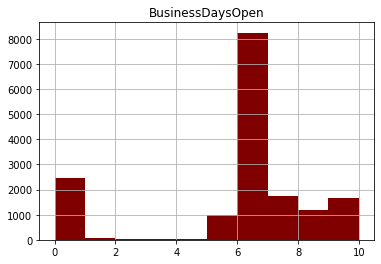

In [8]:
snow.hist(column='BusinessDaysOpen',color='maroon')

array([[<AxesSubplot:title={'center':'BusinessDaysOpen'}>]], dtype=object)

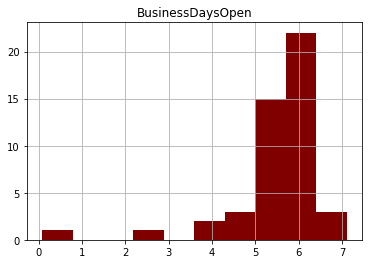

In [9]:
weeklysnow.hist(column='BusinessDaysOpen',color='maroon')

array([[<AxesSubplot:title={'center':'MeetsSLA'}>]], dtype=object)

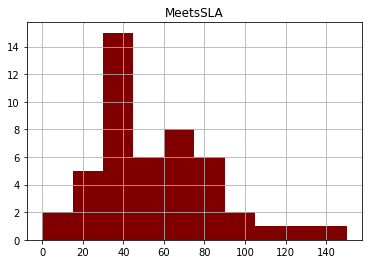

In [10]:
weeklysnow.hist(column='MeetsSLA',color='maroon')

array([[<AxesSubplot:title={'center':'KnowledgeArticle'}>]], dtype=object)

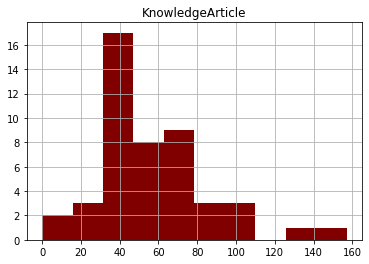

In [11]:
weeklysnow.hist(column='KnowledgeArticle',color='maroon')

array([[<AxesSubplot:title={'center':'number'}>]], dtype=object)

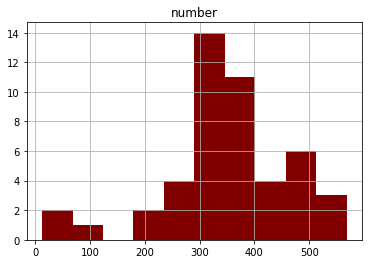

In [12]:
weeklysnow.hist(column='number',color='maroon')

In [13]:
weeklysnow['number'].max()

568

In [14]:
weeklysnow

,number,KnowledgeArticle,BusinessDaysOpen,MeetsSLA,KnowledgeArticleSLA
Request_Week,,,,,
1,404,52,5.952970,44,41
2,568,89,6.154930,66,60
3,469,98,5.754797,77,64
4,499,73,5.889780,61,56
5,383,62,5.780679,55,50
6,338,67,5.402367,51,49
7,400,48,5.962500,35,27
8,330,46,5.627273,40,34
9,354,71,5.282486,62,54


In [15]:
snow['BusinessDaysOpen'].describe()

count    16455.000000
mean         5.612458
std          2.662783
min          0.000000
25%          6.000000
50%          6.000000
75%          7.000000
max         10.000000
Name: BusinessDaysOpen, dtype: float64

In [16]:
print('{:.0%}'.format(snow['MeetsSLA'].sum()/snow['number'].count()) + ' of incidents meet their SLA')
print('{:.0%}'.format(snow['KnowledgeArticleSLA'].sum()/snow['KnowledgeArticle'].sum()) + ' of incidents with knowledge articles meet their SLA')
print('{:.0%}'.format(samplestatskb.iloc[0]['MeetsSLA']/samplestatskb.iloc[0]['number']) + '  of incidents without a knowledge article meet their SLA')

16% of incidents meet their SLA
79% of incidents with knowledge articles meet their SLA
3%  of incidents without a knowledge article meet their SLA


In [17]:
monthstats = monthlyroster[['TotalMonthlyHeadcount', 'StaffMonthlyHeadcount',
       'StudentMonthlyHeadcount', 'WeightedTotalMonthlyHeadcount']].describe()

monthstats

,TotalMonthlyHeadcount,StaffMonthlyHeadcount,StudentMonthlyHeadcount,WeightedTotalMonthlyHeadcount
count,12.000000,12.000000,12.000000,12.00000
mean,19.333333,8.250000,11.083333,13.03125
std,8.150107,0.452267,7.763063,3.91389
min,13.000000,8.000000,5.000000,10.00000
25%,14.000000,8.000000,6.000000,10.50000
50%,14.000000,8.000000,6.000000,10.50000
75%,28.250000,8.250000,20.000000,17.00000
max,32.000000,9.000000,23.000000,19.25000


In [18]:
print('MONTHLY HEADCOUNT STATS')
print('---------------------------------------------------------------')
print('The average monthly headcount for CSC is ' + '{:.4}'.format(monthlyroster['TotalMonthlyHeadcount'].mean()))
print('The average monthly staff headcount for CSC is ' + '{:.4}'.format(monthlyroster['StaffMonthlyHeadcount'].mean()))
print('The average monthly student headcount for CSC is ' + '{:.4}'.format(monthlyroster['StudentMonthlyHeadcount'].mean()))

print('---------------------------------------------------------------')
print('The average FTE weighted monthly headcount for CSC is ' + '{:.4}'.format(monthlyroster['WeightedTotalMonthlyHeadcount'].mean()))
print('The highest FTE weighted monthly headcount for CSC is ' + '{:}'.format(monthlyroster['WeightedTotalMonthlyHeadcount'].max()))
print('The lowest FTE weighted monthly headcount for CSC is ' + '{:}'.format(monthlyroster['WeightedTotalMonthlyHeadcount'].min()))

print('---------------------------------------------------------------')
print('WEEKLY HEADCOUNT STATS')
print('---------------------------------------------------------------')
print('The average weekly headcount for CSC is ' + '{:.4}'.format(weeklyroster['TotalWeeklyHeadcount'].mean()))
print('The average weekly staff headcount for CSC is ' + '{:.4}'.format(weeklyroster['StaffWeeklyHeadcount'].mean()))
print('The average weekly student headcount for CSC is ' + '{:.4}'.format(weeklyroster['StudentWeeklyHeadcount'].mean()))

print('---------------------------------------------------------------')
print('The average FTE weighted monthly headcount for CSC is ' + '{:.4}'.format(weeklyroster['WeightedTotalWeeklyHeadcount'].mean()))
print('The highest FTE weighted monthly headcount for CSC is ' + '{:}'.format(weeklyroster['WeightedTotalWeeklyHeadcount'].max()))
print('The lowest FTE weighted monthly headcount for CSC is ' + '{:}'.format(weeklyroster['WeightedTotalWeeklyHeadcount'].min()))



MONTHLY HEADCOUNT STATS
---------------------------------------------------------------
The average monthly headcount for CSC is 19.33
The average monthly staff headcount for CSC is 8.25
The average monthly student headcount for CSC is 11.08
---------------------------------------------------------------
The average FTE weighted monthly headcount for CSC is 13.03
The highest FTE weighted monthly headcount for CSC is 19.25
The lowest FTE weighted monthly headcount for CSC is 10.0
---------------------------------------------------------------
WEEKLY HEADCOUNT STATS
---------------------------------------------------------------
The average weekly headcount for CSC is 18.28
The average weekly staff headcount for CSC is 8.2
The average weekly student headcount for CSC is 10.08
---------------------------------------------------------------
The average FTE weighted monthly headcount for CSC is 12.53
The highest FTE weighted monthly headcount for CSC is 19.25
The lowest FTE weighted monthly

<AxesSubplot:xlabel='WeekNumber'>

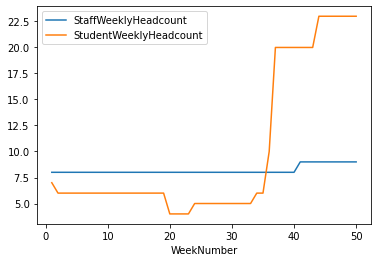

In [19]:
weeklyroster.plot(kind="line", x='WeekNumber', y=['StaffWeeklyHeadcount','StudentWeeklyHeadcount'])

<AxesSubplot:xlabel='MonthNumber'>

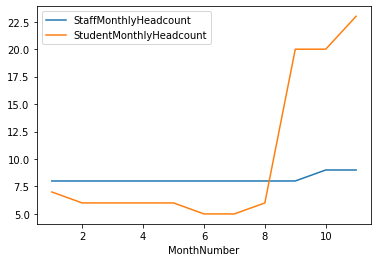

In [20]:
month.plot(kind="line", x='MonthNumber', y=['StaffMonthlyHeadcount','StudentMonthlyHeadcount'])

<AxesSubplot:xlabel='MonthNumber'>

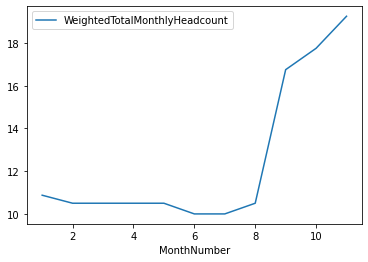

In [21]:
month.plot(kind="line", x='MonthNumber', y=['WeightedTotalMonthlyHeadcount'])

array([[<AxesSubplot:title={'center':'WeightedTotalMonthlyHeadcount'}>]],
      dtype=object)

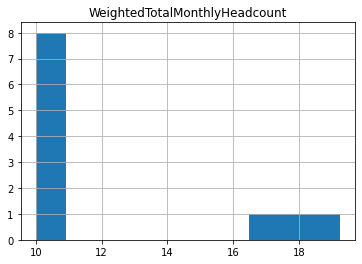

In [22]:
month.hist(column='WeightedTotalMonthlyHeadcount')

In [55]:
week['WeightedTotalWeeklyHeadcount'].describe()

count    46.000000
mean     11.948370
std       3.174833
min       9.750000
25%      10.000000
50%      10.500000
75%      10.781250
max      19.250000
Name: WeightedTotalWeeklyHeadcount, dtype: float64

array([[<AxesSubplot:title={'center':'WeightedTotalWeeklyHeadcount'}>]],
      dtype=object)

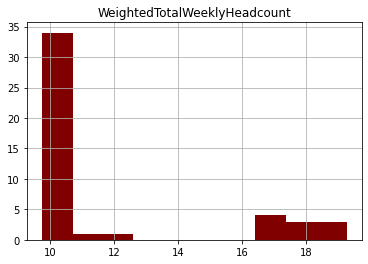

In [23]:
week.hist(column='WeightedTotalWeeklyHeadcount', color='maroon')

<AxesSubplot:xlabel='WeekNumber'>

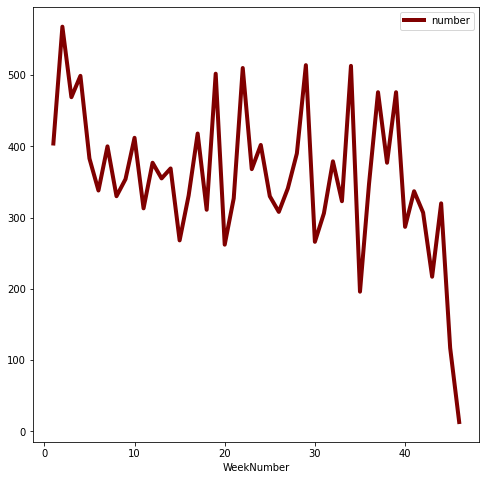

In [24]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 10})
week.plot(kind='line', x='WeekNumber', y='number', figsize=(8,8), color='maroon', linewidth=4)

For WeightedTotalMonthlyHeadcount and BusinessDaysOpen there is a correlation of -0.33564145158951647 with a significance value of 0.3129298636768197


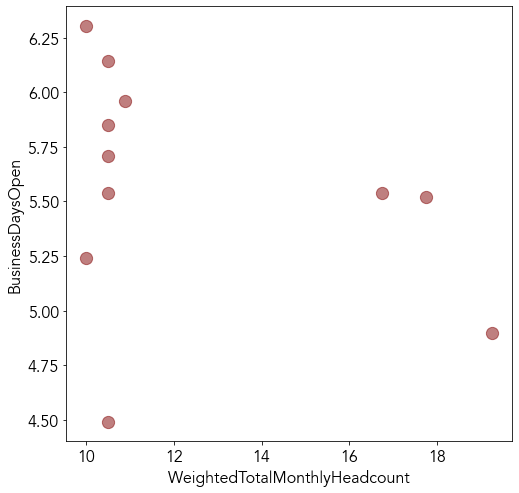

In [25]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
plt.rcParams.update({'font.sans-serif':'Avenir'})
plt.rcParams.update({'font.size': 16})

def get_correlations(df, col1, col2):
    df.plot(kind='scatter', x=col1, y=col2, figsize=(8,8), s=150, c='maroon', alpha=0.5)
    coef, pval = pearsonr(df[col1], df[col2])
    print('For ' + col1 + ' and ' + col2 + ' there is a correlation of ' + str(coef) + ' with a significance value of ' + str(pval))

get_correlations(month, 'WeightedTotalMonthlyHeadcount', 'BusinessDaysOpen')
    

For WeightedTotalWeeklyHeadcount and BusinessDaysOpen there is a correlation of -0.34567003248037365 with a significance value of 0.018624022576834137


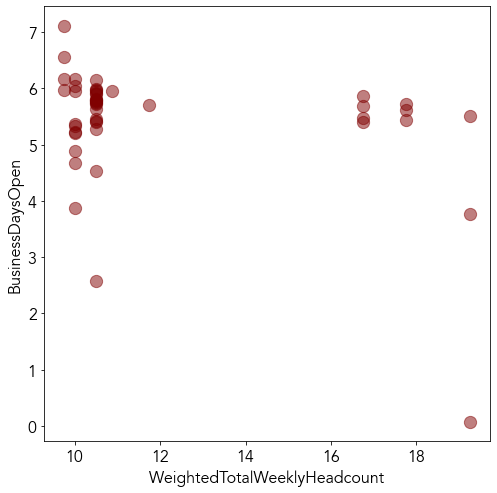

In [26]:
get_correlations(week, 'WeightedTotalWeeklyHeadcount', 'BusinessDaysOpen')

For number and BusinessDaysOpen there is a correlation of 0.6196802708525948 with a significance value of 4.387778001475531e-06


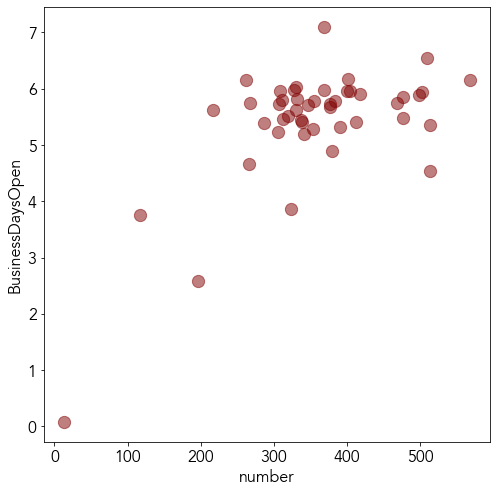

In [27]:
get_correlations(week, 'number', 'BusinessDaysOpen')

For WeekNumber and BusinessDaysOpen there is a correlation of -0.4411932973254711 with a significance value of 0.0021469452499504045


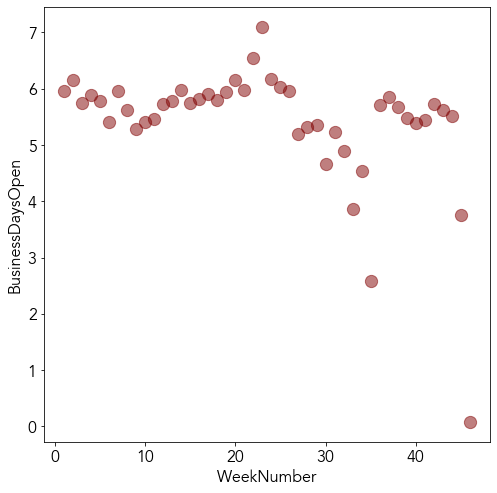

In [28]:
get_correlations(week, 'WeekNumber', 'BusinessDaysOpen')

In [29]:
week.columns

Index(['number', 'KnowledgeArticle', 'BusinessDaysOpen', 'MeetsSLA',
       'KnowledgeArticleSLA', 'index', 'TotalWeeklyHeadcount',
       'StaffWeeklyHeadcount', 'StudentWeeklyHeadcount',
       'WeightedTotalWeeklyHeadcount', 'WeekNumber', 'SLA%', 'KB%'],
      dtype='object')

For WeightedTotalWeeklyHeadcount and SLA% there is a correlation of 0.36332903631016733 with a significance value of 0.013069656984938074


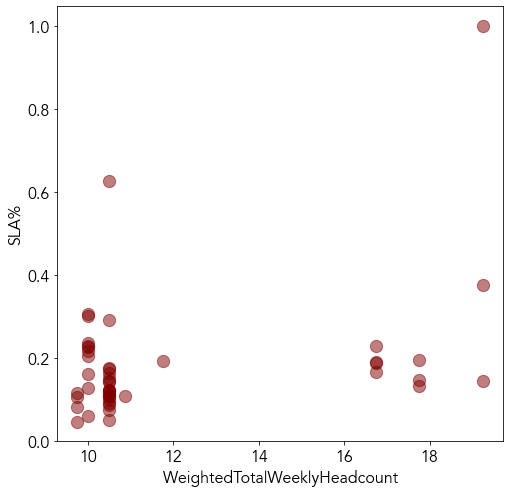

In [30]:
get_correlations(week, 'WeightedTotalWeeklyHeadcount', 'SLA%')

For WeightedTotalWeeklyHeadcount and KB% there is a correlation of 0.24633128867967344 with a significance value of 0.09888958362055185


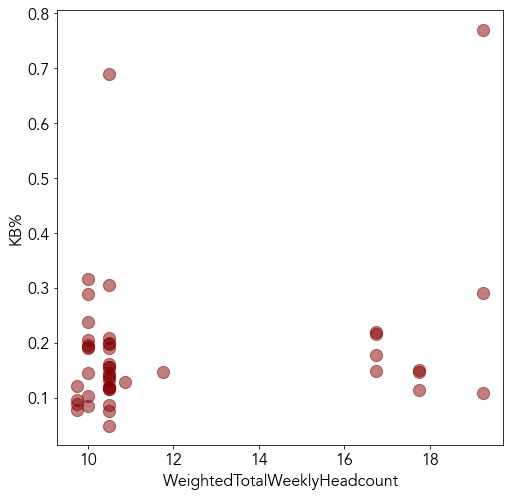

In [31]:
get_correlations(week, 'WeightedTotalWeeklyHeadcount', 'KB%')

For KB% and SLA% there is a correlation of 0.9655200765444232 with a significance value of 2.3728175673129913e-27


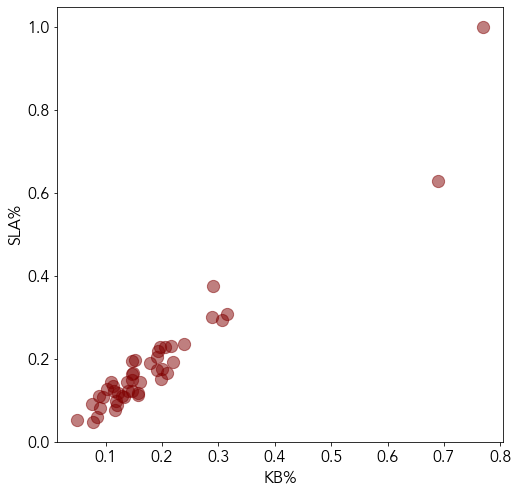

In [32]:
get_correlations(week,'KB%', 'SLA%')

For WeightedTotalWeeklyHeadcount and SLA% there is a correlation of 0.36332903631016733 with a significance value of 0.013069656984938074


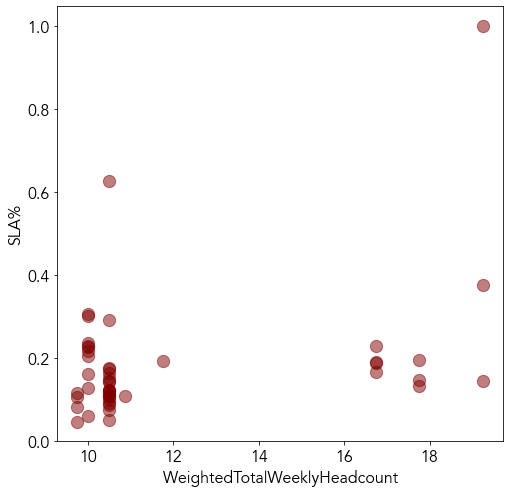

In [33]:
get_correlations(week,'WeightedTotalWeeklyHeadcount', 'SLA%')

For KB% and BusinessDaysOpen there is a correlation of -0.9386769623702073 with a significance value of 5.712227374731603e-22


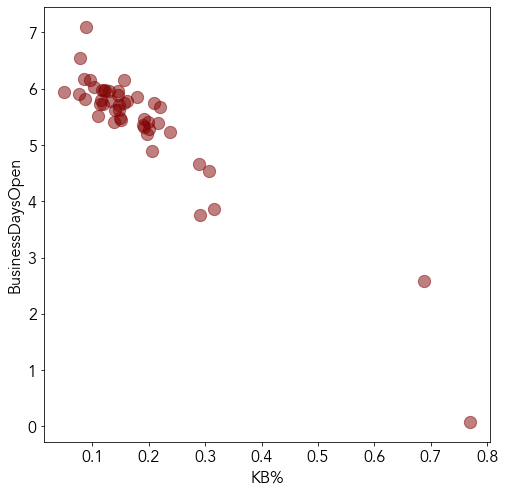

In [34]:
get_correlations(week,'KB%', 'BusinessDaysOpen')

For StaffWeeklyHeadcount and SLA% there is a correlation of 0.3642162104159606 with a significance value of 0.012832709479821021


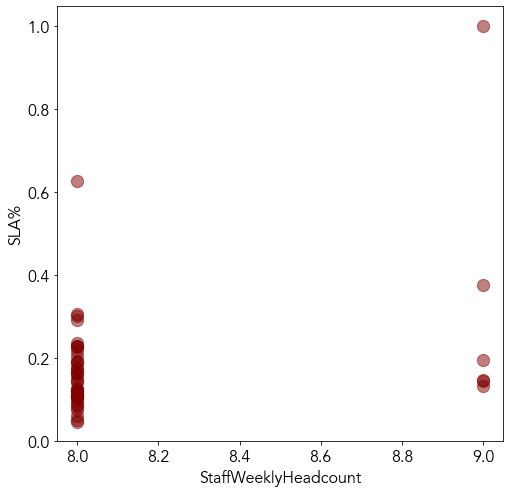

In [35]:
get_correlations(week,'StaffWeeklyHeadcount', 'SLA%')

For StudentWeeklyHeadcount and SLA% there is a correlation of 0.3524256590608765 with a significance value of 0.016300487831685834


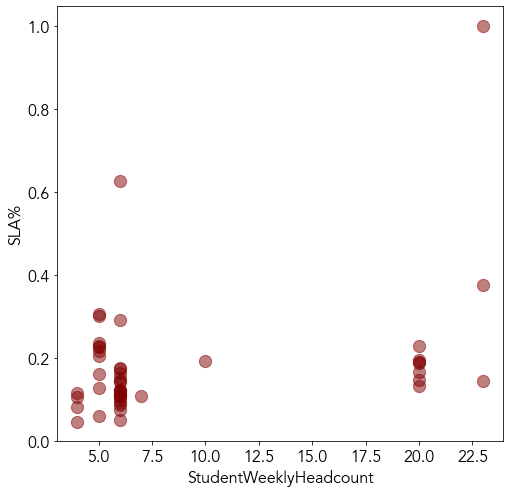

In [36]:
get_correlations(week,'StudentWeeklyHeadcount', 'SLA%')

In [37]:
week.columns

Index(['number', 'KnowledgeArticle', 'BusinessDaysOpen', 'MeetsSLA',
       'KnowledgeArticleSLA', 'index', 'TotalWeeklyHeadcount',
       'StaffWeeklyHeadcount', 'StudentWeeklyHeadcount',
       'WeightedTotalWeeklyHeadcount', 'WeekNumber', 'SLA%', 'KB%'],
      dtype='object')

In [38]:
import statsmodels.api as sm

def getOLS(X, y):
    X2 = X.copy()
    X2['const'] = 1
    est = sm.OLS(y, X2)
    est2 = est.fit()
    return est2

y = week['BusinessDaysOpen'].values
weekdummies = pd.get_dummies(week.WeekNumber, drop_first=True,prefix='Week')
week.merge(weekdummies, left_index=True, right_index=True)
X = week[['StaffWeeklyHeadcount', 'StudentWeeklyHeadcount', 'KB%', 
                  'number'
                ]].copy()

busdays = getOLS(X, y)
busdays.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     106.0
Date:                Wed, 02 Feb 2022   Prob (F-statistic):           4.72e-21
Time:                        16:37:38   Log-Likelihood:                -12.817
No. Observations:                  46   AIC:                             35.63
Df Residuals:                      41   BIC:                             44.78
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
StaffWeeklyHeadcount      -0.5352      0.253     -2.114      0.041      -1.047      -0.024
StudentWeeklyHeadcount     0.0047      0.012      0.385      0.703      -0.020       0.029
KB%                       -7.1474      0.462    -15.463      0.000      -8.081      -6.214
number                     0.0007      0.001      0.967      0.339      -0.001       0.002
const                     10.8136      2.117      5.108      0.000       6.538      15.089
==============================================================================
Omnibus:                        4.488   Durbin-Watson:                   1.548
Prob(Omnibus):                  0.106   Jarque-Bera (JB):                3.404
Skew:                           0.472   Prob(JB):                        0.182
Kurtosis:                       3.940   Cond. No.                     1.59e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
busdays.params

StaffWeeklyHeadcount      -0.535203
StudentWeeklyHeadcount     0.004686
KB%                       -7.147411
number                     0.000650
const                     10.813579
dtype: float64

In [40]:
staff = 10
student = 20
KB = week['KB%'].mean()
number = week['number'].mean()
(-0.535203 * staff) + (0.004686 * student) + (-7.147411 * KB) + (0.000650 * number) + 10.813579

4.469252306903143

In [41]:
X2 = week[['WeightedTotalWeeklyHeadcount', 'KB%', 
                  'number'
                ]].copy()
X2['AdjustedKB'] = X2['KB%'] * 100
X3 = X2[['WeightedTotalWeeklyHeadcount', 'AdjustedKB', 
                  'number'
                ]].copy()
y2 = week['BusinessDaysOpen'].values

busdays2 = getOLS(X3, y2)
busdays2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     130.7
Date:                Wed, 02 Feb 2022   Prob (F-statistic):           2.52e-21
Time:                        16:37:38   Log-Likelihood:                -14.957
No. Observations:                  46   AIC:                             37.91
Df Residuals:                      42   BIC:                             45.23
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
WeightedTotalWeeklyHeadcount    -0.0312      0.018     -1.744      0.089      -0.067       0.005
AdjustedKB                      -0.0699      0.005    -14.825      0.000      -0.079      -0.060
number                           0.0012      0.001      1.882      0.067   -8.62e-05       0.002
const                            6.6540      0.395     16.830      0.000       5.856       7.452
==============================================================================
Omnibus:                        3.756   Durbin-Watson:                   1.619
Prob(Omnibus):                  0.153   Jarque-Bera (JB):                2.617
Skew:                           0.453   Prob(JB):                        0.270
Kurtosis:                       3.738   Cond. No.                     2.85e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
X2 = week[['WeightedTotalWeeklyHeadcount', 'KB%', 
                  'number'
                ]].copy()
y2 = week['BusinessDaysOpen'].values

busdays2 = getOLS(X2, y2)
busdays2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     130.7
Date:                Wed, 02 Feb 2022   Prob (F-statistic):           2.52e-21
Time:                        16:37:38   Log-Likelihood:                -14.957
No. Observations:                  46   AIC:                             37.91
Df Residuals:                      42   BIC:                             45.23
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
WeightedTotalWeeklyHeadcount    -0.0312      0.018     -1.744      0.089      -0.067       0.005
KB%                             -6.9948      0.472    -14.825      0.000      -7.947      -6.043
number                           0.0012      0.001      1.882      0.067   -8.62e-05       0.002
const                            6.6540      0.395     16.830      0.000       5.856       7.452
==============================================================================
Omnibus:                        3.756   Durbin-Watson:                   1.619
Prob(Omnibus):                  0.153   Jarque-Bera (JB):                2.617
Skew:                           0.453   Prob(JB):                        0.270
Kurtosis:                       3.738   Cond. No.                     3.85e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
busdays2.params

WeightedTotalWeeklyHeadcount   -0.031193
KB%                            -6.994797
number                          0.001196
const                           6.653981
dtype: float64

In [44]:
print(week['KB%'].mean())
print(week['number'].mean())

0.18438804315009544
356.7391304347826


In [58]:
def getPredictions(model, headcountrange, kb = week['KB%'].mean()):
    headcountcoef = model.params[0]
    kbcoef = model.params[1]
    numbercoef = model.params[2]
    constant = model.params[-1]
    number = week['number'].mean()
    predictions = []
    for weightedheadcount in headcountrange:
        prediction = (headcountcoef * weightedheadcount) + (kbcoef * kb) + (numbercoef * number) + constant
        predictions.append(prediction)
    return predictions

def scenarioModeling(model, headcountrange):
    predictionsmean = getPredictions(model, headcountrange)
    predictionsquarter = getPredictions(model, headcountrange, .25)
    meanpredictionsthird = getPredictions(model, headcountrange, .33)
    meanpredictionshalf = getPredictions(model, headcountrange, .5)
    meanpredictionstwothirds = getPredictions(model, headcountrange, .75)
    return predictionsmean, predictionsquarter, meanpredictionsthird, meanpredictionshalf, meanpredictionstwothirds

headcountrange = list(range(1, 51))

predictbusdays, predictbusdaysquarterkb, predictbusdaysthirdkb, predictbusdayshalfkb, predictbusdaystwothirdskb =  scenarioModeling(busdays2, headcountrange)


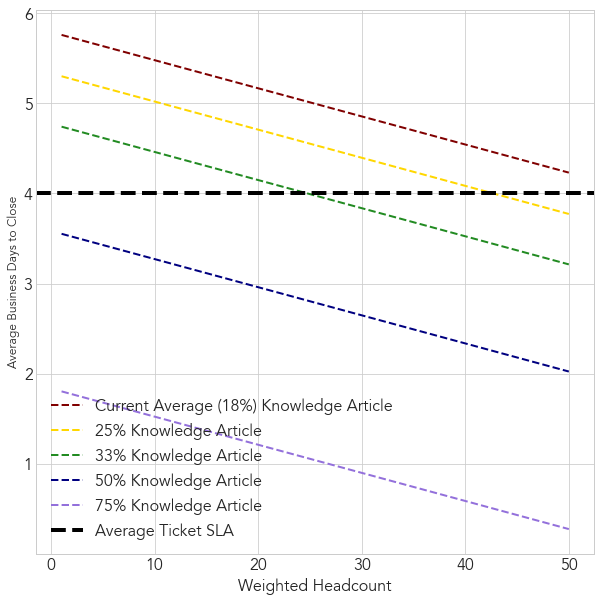

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt

def plotScenarios(headcountrange, predictionlist):
    plt.style.use('seaborn-whitegrid')
    plt.rcParams.update({'font.sans-serif':'Avenir'})
    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(10, 10))
    plt.plot(headcountrange, predictionlist[0], color="maroon", linestyle="--", label="Current Average (18%) Knowledge Article", linewidth=2)
    plt.plot(headcountrange, predictionlist[1], color="gold", linestyle="--",label="25% Knowledge Article", linewidth=2)
    plt.plot(headcountrange, predictionlist[2], color="forestgreen", linestyle="--", label="33% Knowledge Article", linewidth=2)
    plt.plot(headcountrange, predictionlist[3], color="navy", linestyle="--", label="50% Knowledge Article", linewidth=2)
    plt.plot(headcountrange, predictionlist[4], color="mediumpurple", linestyle="--", label="75% Knowledge Article", linewidth=2)
    plt.xlabel("Weighted Headcount", fontsize=16)
    plt.legend(loc="best", fontsize=16)

plotScenarios(headcountrange, [predictbusdays, predictbusdaysquarterkb, predictbusdaysthirdkb, predictbusdayshalfkb, predictbusdaystwothirdskb])
plt.axhline(y=4, label="Average Ticket SLA", color='black', linestyle='--', linewidth=4)
plt.ylabel("Average Business Days to Close", fontsize=12)
plt.legend(loc="best", fontsize=16)

In [47]:
# Tried to do a beta regression to account for proportion in DV, not currently working - proceeding with OLS anyway
# import statsmodels.othermod.betareg as beta

# endog = week['SLA%'].values
# exog = X.copy()
# exog['const'] = 1
# mod = beta.BetaModel(endog, exog)
# rslt = mod.fit()
# print(rslt.summary())

y = week['SLA%'].values
slaols = getOLS(X2, y)
slaols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     288.3
Date:                Wed, 02 Feb 2022   Prob (F-statistic):           4.90e-28
Time:                        16:37:39   Log-Likelihood:                 90.993
No. Observations:                  46   AIC:                            -174.0
Df Residuals:                      42   BIC:                            -166.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
WeightedTotalWeeklyHeadcount     0.0055      0.002      3.053      0.004       0.002       0.009
KB%                              1.0546      0.047     22.368      0.000       0.959       1.150
number                          -0.0001   6.35e-05     -2.064      0.045      -0.000   -2.91e-06
const                           -0.0264      0.040     -0.669      0.507      -0.106       0.053
==============================================================================
Omnibus:                        7.166   Durbin-Watson:                   1.622
Prob(Omnibus):                  0.028   Jarque-Bera (JB):               12.465
Skew:                           0.078   Prob(JB):                      0.00196
Kurtosis:                       5.545   Cond. No.                     3.85e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [48]:
# Tried to do a beta regression to account for proportion in DV, not currently working - proceeding with OLS anyway
# import statsmodels.othermod.betareg as beta

# endog = week['SLA%'].values
# exog = X.copy()
# exog['const'] = 1
# mod = beta.BetaModel(endog, exog)
# rslt = mod.fit()
# print(rslt.summary())

y = week['SLA%'].values
slaols = getOLS(X3, y)
slaols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     288.3
Date:                Wed, 02 Feb 2022   Prob (F-statistic):           4.90e-28
Time:                        16:37:39   Log-Likelihood:                 90.993
No. Observations:                  46   AIC:                            -174.0
Df Residuals:                      42   BIC:                            -166.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
WeightedTotalWeeklyHeadcount     0.0055      0.002      3.053      0.004       0.002       0.009
AdjustedKB                       0.0105      0.000     22.368      0.000       0.010       0.011
number                          -0.0001   6.35e-05     -2.064      0.045      -0.000   -2.91e-06
const                           -0.0264      0.040     -0.669      0.507      -0.106       0.053
==============================================================================
Omnibus:                        7.166   Durbin-Watson:                   1.622
Prob(Omnibus):                  0.028   Jarque-Bera (JB):               12.465
Skew:                           0.078   Prob(JB):                      0.00196
Kurtosis:                       5.545   Cond. No.                     2.85e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0, 0.5, 'Percentage of Incidents Meeting SLA')

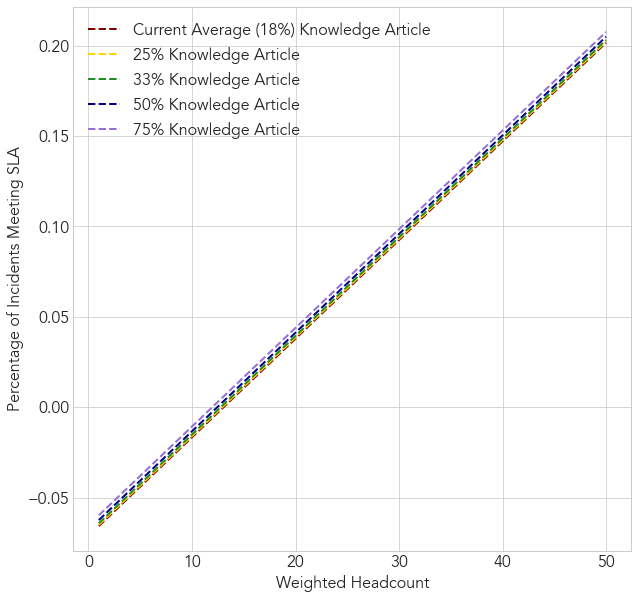

In [49]:
predictslaols, predictslaolsquarterkb, predictslaolsthirdkb, predictslaolshalfkb, predictslaolstwothirdskb =  scenarioModeling(slaols, headcountrange)

plotScenarios(headcountrange, [predictslaols, predictslaolsquarterkb, predictslaolsthirdkb, predictslaolshalfkb, predictslaolstwothirdskb])
plt.ylabel("Percentage of Incidents Meeting SLA", fontsize=16)

In [50]:
# A version of being able to do beta regression, but seems wrong. Ignore following for now :) 

X2['const'] = 1
binom_glm = sm.GLM(y, X2, family=sm.families.Binomial())
slaglm = binom_glm.fit()
print(slaglm.summary2())

                     Results: Generalized linear model
Model:                    GLM                  AIC:                35.2173  
Link Function:            Logit                BIC:                -160.2062
Dependent Variable:       y                    Log-Likelihood:     -13.609  
Date:                     2022-02-02 16:37     LL-Null:            -16.384  
No. Observations:         46                   Deviance:           0.59676  
Df Model:                 3                    Pearson chi2:       0.528    
Df Residuals:             42                   Scale:              1.0000   
Method:                   IRLS                                              
----------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
WeightedTotalWeeklyHeadcount  0.0443   0.1344  0.3293 0.7420 -0.2192  0.3077
KB%                  

Text(0, 0.5, 'Percentage of Incidents Meeting SLA')

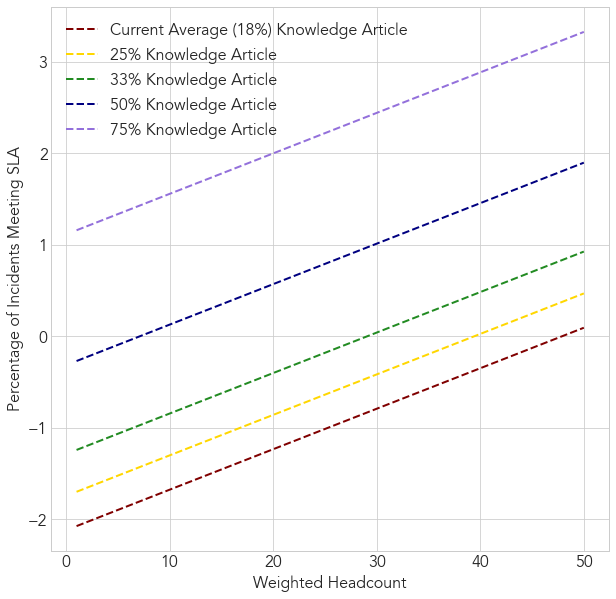

In [51]:
predictslaglm, predictslaglmquarterkb, predictslaglmthirdkb, predictslaglmhalfkb, predictslaglmtwothirdskb =  scenarioModeling(slaglm, headcountrange)

plotScenarios(headcountrange, [predictslaglm, predictslaglmquarterkb, predictslaglmthirdkb, predictslaglmhalfkb, predictslaglmtwothirdskb])
plt.ylabel("Percentage of Incidents Meeting SLA", fontsize=16)